# MLP (Chien, Jieun)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import mean_squared_error
from itertools import product
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
train_df = pd.read_csv("preprocessed_train.csv")
test_df = pd.read_csv("preprocessed_test.csv")

print(train_df.shape)
print(test_df.shape)

(2689889, 49)
(1383413, 49)


In [4]:
def feature_target_split(train_df, test_df):
    # sort dataset by columen "flightDate_as_int"
    train_df_sorted = train_df.sort_values(by='flightDate_as_int')
    test_df_sorted = test_df.sort_values(by='flightDate_as_int')

    # features and target split
    # train set
    x_train = train_df_sorted.drop(columns=['baseFare']) # DataFrame
    y_train = train_df_sorted['baseFare'] # Series

    # test set
    x_test = test_df_sorted.drop(columns=['baseFare'])
    y_test = test_df_sorted['baseFare']

    # align train and test column
    x_test = x_test[x_train.columns]

    return x_train, x_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = feature_target_split(train_df, test_df)

In [6]:
def train_val_split(df_x, df_y, train_size: float = 0.8):
    # sort dataset by columen "flightDate_as_int"
    # df_sorted = df.sort_values(by='flightDate_as_int')
    #!! Assume the index is aligned!!

    # 80% and 20% split
    split_index = int(len(df_x)*train_size)

    # features and target split
    x_train = df_x[:split_index]
    y_train = df_y[:split_index]

    x_val = df_x[split_index:]
    y_val = df_y[split_index:]

    return x_train, x_val, y_train, y_val

## Features Normalization

In [7]:
numerical_features = [
    'seatsRemaining',
    'travelDuration_minutes',
    'searchDate_as_int',
    'flightDate_as_int',
    'dayOfWeekNum',
    'monthNum',
    'daysUntilFlight',
    'num_legs',
    'totalTransferTime',
    'totalFlightTime',
    'total_distance',
]

In [8]:
scaler_X = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler_X.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler_X.transform(X_test[numerical_features])

## MLP training

In [9]:
# Build a PyTorch MLP model
class MLPRegression(nn.Module):
    def __init__(self, input_dim, drop_out: float = 0.2):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(drop_out),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(drop_out), 
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(drop_out), 
            
            nn.Linear(128, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)

In [10]:
def plot_perf(train: list, val: list, name: list, eval_every: int = 1):
    assert len(train) == len(val) == len(name)
    
    f, host = plt.subplots(figsize=(12, 6))
    handles = []
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    for i in range(len(train)):
        if i == 0:  # For loss values
            ax = host
            
            # For train_losses, take only values at evaluation points
            num_batches_per_epoch = len(train[i]) // (len(val[i]) * eval_every)
            train_indices = [j * num_batches_per_epoch - 1 for j in range(1, len(val[i]) + 1)]
            train_values = [train[i][idx] if idx < len(train[i]) else train[i][-1] for idx in train_indices]
            
            # Plot with epochs on x-axis
            epochs = np.arange(0, len(val[i]) * eval_every, eval_every)
            handles += ax.plot(epochs, train_values, label=f"{name[i]}, train", c=colors[i*2])
            handles += ax.plot(epochs, val[i], label=f"{name[i]}, val", c=colors[i*2+1])
        else:  # For accuracy values
            ax = host.twinx()
            handles += ax.plot(epochs, train[i], label=f"{name[i]}, train", c=colors[i*2])
            handles += ax.plot(epochs, val[i], label=f"{name[i]}, val", c=colors[i*2+1])
            
        ax.set_ylabel(name[i])
    
    host.set_xlabel("Epochs")
    plt.grid(linestyle="--")
    plt.legend(handles=handles, loc="center right")
    plt.title("Training and Validation Performance")
    plt.tight_layout()
    plt.show()

In [11]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_state = None
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def train_model(
    X_train,
    y_train,
    X_test,
    y_test,
    model: nn.Module,
    lr: float = 1e-3,
    batch_size: int = 128,
    epochs: int = 100,
    eval_every: int = 1,
    patience: int = 15,   
    save_path: str = None,
) -> dict[str, list[float]]:
    
    # Split data into train and validation.
    x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Create PyTorch dataset and data loader
    x_train = torch.tensor(x_train.values, dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(DEVICE)
    x_val = torch.tensor(x_val.values, dtype=torch.float32).to(DEVICE)
    y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(DEVICE)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Set up logging.
    results = {
        "train_losses": [],
        "val_losses": [],
        "test_losses": [],
        "train_rmse": [],
        "val_rmse": [],
        "test_rmse": [],
        "test_mae": [],
        "test_r2": [],
    }
    t0 = time.time()

    # Send model to accelerator (if available)
    model = model.to(DEVICE)

    # Define loss function and optimizer.
    loss_fn = nn.MSELoss() # (use mean squared error)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # (use, e.g., Adam)
    
    # Initialize EarlyStopping
    early_stopper = EarlyStopping(patience=patience, verbose=True)
    
    # Training loop.
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss /= len(train_loader)
        results["train_losses"].append(epoch_loss)

        # Evaluation + EarlyStopping
        model.eval()
        with torch.no_grad():
            train_preds = model(x_train)
            val_preds = model(x_val)

            train_rmse = torch.sqrt(torch.mean((train_preds - y_train) ** 2))
            val_rmse = torch.sqrt(torch.mean((val_preds - y_val) ** 2))

            val_loss = loss_fn(val_preds, y_val)

            results["train_rmse"].append(train_rmse.cpu().numpy())
            results["val_rmse"].append(val_rmse.cpu().numpy())
            results["val_losses"].append(val_loss.item())

        print(
            f"epoch {epoch}, train_loss {loss.item():.3e}, val_loss {val_loss.item():.3e}, "
            f"train_rmse {train_rmse:.1f}, val_rmse {val_rmse:.1f}"
        )

        # Check EarlyStopping
        early_stopper(val_loss.item(), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Restore the best model weights
    if early_stopper.best_state is not None:
        model.load_state_dict(early_stopper.best_state)
        print("Restored best model weights.")
    
    # Save model
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved model to {save_path}")

    # Final test evaluation
    x_test = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

    model.eval()
    with torch.no_grad():
        test_loss = loss_fn(model(x_test), y_test)
        test_preds = model(x_test).cpu().numpy()

    results["test_losses"].append(test_loss.item())
    results["test_rmse"].append(rmse(y_test.cpu().numpy(), test_preds))
    results["test_mae"].append(mean_absolute_error(y_test.cpu().numpy(), test_preds))
    results["test_r2"].append(r2_score(y_test.cpu().numpy(), test_preds))
    
    print(
        f"Final result: "
        f"train_loss {results['train_losses'][-1]:.3e}, "
        f"val_loss {results['val_losses'][-1]:.3e}, "
        f"test_loss {results['test_losses'][-1]:.3e}, "
        f"train_rmse {results['train_rmse'][-1]:.1f}, "
        f"val_rmse {results['val_rmse'][-1]:.1f}, "
        f"test_rmse {results['test_rmse'][-1]:.1f}, "
        f"test_mae {results['test_mae'][-1]:.1f}, "
        f"test_r2 {results['test_r2'][-1]:.1f}"     
    )

    results["config"] = {
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "num_params": sum(p.numel() for p in model.parameters() if p.requires_grad),
    }
    
    plot_perf(
            train = [results['train_losses'], results['train_rmse']],
            val = [results['val_losses'], results['val_rmse']],
            name = ["loss", "root mean square error"],eval_every=eval_every
        )
    print('ploted')

    return results

epoch 0, train_loss 4.872e+03, val_loss 2.007e+04, train_rmse 206.7, val_rmse 141.7
epoch 1, train_loss 7.248e+03, val_loss 1.577e+04, train_rmse 167.4, val_rmse 125.6
epoch 2, train_loss 1.071e+04, val_loss 1.587e+04, train_rmse 150.4, val_rmse 126.0
EarlyStopping counter: 1/15
epoch 3, train_loss 5.363e+03, val_loss 1.436e+04, train_rmse 143.3, val_rmse 119.8
epoch 4, train_loss 3.852e+03, val_loss 1.261e+04, train_rmse 136.1, val_rmse 112.3
epoch 5, train_loss 5.730e+03, val_loss 1.464e+04, train_rmse 135.6, val_rmse 121.0
EarlyStopping counter: 1/15
epoch 6, train_loss 5.752e+03, val_loss 1.254e+04, train_rmse 133.8, val_rmse 112.0
epoch 7, train_loss 5.931e+03, val_loss 1.349e+04, train_rmse 135.0, val_rmse 116.1
EarlyStopping counter: 1/15
epoch 8, train_loss 4.303e+03, val_loss 1.244e+04, train_rmse 133.6, val_rmse 111.5
epoch 9, train_loss 4.158e+03, val_loss 1.161e+04, train_rmse 131.5, val_rmse 107.7
epoch 10, train_loss 4.419e+03, val_loss 1.164e+04, train_rmse 130.8, val_rm

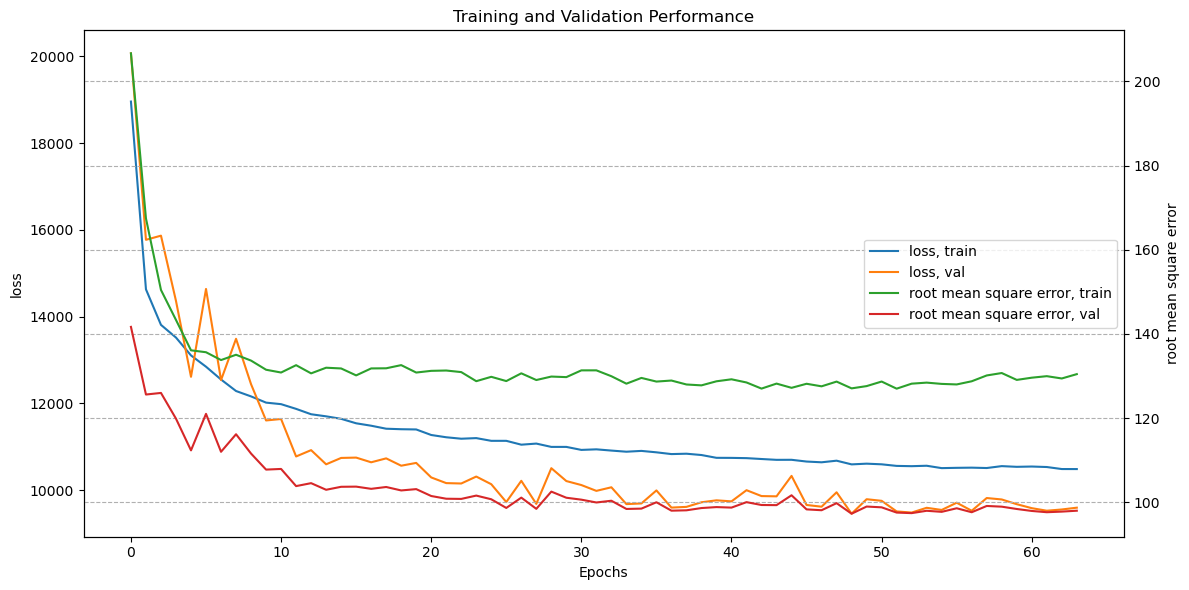

ploted


In [16]:
fnn = MLPRegression(input_dim=X_train_scaled.shape[1])
results_mlp = train_model(
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model=fnn,
)

## Hyperparameter Tuning with Random Search

In [45]:
import random

def perform_random_search(all_combinations, num_trials: int):

    all_results = {}
    model_params = {}

    selected_combinations = all_combinations[:num_trials]

    for trial, (lr, batch_size, patience, dropout) in enumerate(selected_combinations):
        config_name = f"trial_{trial}_lr{lr}_bs{batch_size}_pat{patience}_do{dropout}"
        save_path = f"models_final/model_{config_name}.pth"
        print(f"Running {config_name}")

        model = MLPRegression(input_dim=X_train_scaled.shape[1], drop_out=dropout)
        
        results = train_model(
            X_train=X_train_scaled,
            y_train=y_train,
            X_test=X_test_scaled,
            y_test=y_test,
            model=model,
            lr=lr,
            batch_size=batch_size,
            patience=patience,
            save_path=save_path, 
        )

        all_results[config_name] = results
        model_params[config_name] = {
            "lr": lr,
            "batch_size": batch_size,
            "patience": patience,
            "dropout": dropout
        }

    return all_results, model_params


Running trial_0_lr0.01_bs64_pat15_do0.0
epoch 0, train_loss 3.560e+03, val_loss 2.847e+04, train_rmse 172.3, val_rmse 168.7
epoch 1, train_loss 2.971e+03, val_loss 2.349e+04, train_rmse 167.6, val_rmse 153.3
epoch 2, train_loss 3.331e+03, val_loss 2.109e+04, train_rmse 160.5, val_rmse 145.2
epoch 3, train_loss 2.868e+03, val_loss 1.779e+04, train_rmse 153.8, val_rmse 133.4
epoch 4, train_loss 3.189e+03, val_loss 1.679e+04, train_rmse 152.3, val_rmse 129.6
epoch 5, train_loss 2.596e+03, val_loss 1.536e+04, train_rmse 148.2, val_rmse 124.0
epoch 6, train_loss 3.279e+03, val_loss 1.523e+04, train_rmse 144.9, val_rmse 123.4
epoch 7, train_loss 3.292e+03, val_loss 1.465e+04, train_rmse 143.8, val_rmse 121.0
epoch 8, train_loss 3.330e+03, val_loss 1.528e+04, train_rmse 143.0, val_rmse 123.6
EarlyStopping counter: 1/15
epoch 9, train_loss 3.675e+03, val_loss 1.580e+04, train_rmse 146.7, val_rmse 125.7
EarlyStopping counter: 2/15
epoch 10, train_loss 3.563e+03, val_loss 1.483e+04, train_rmse 1

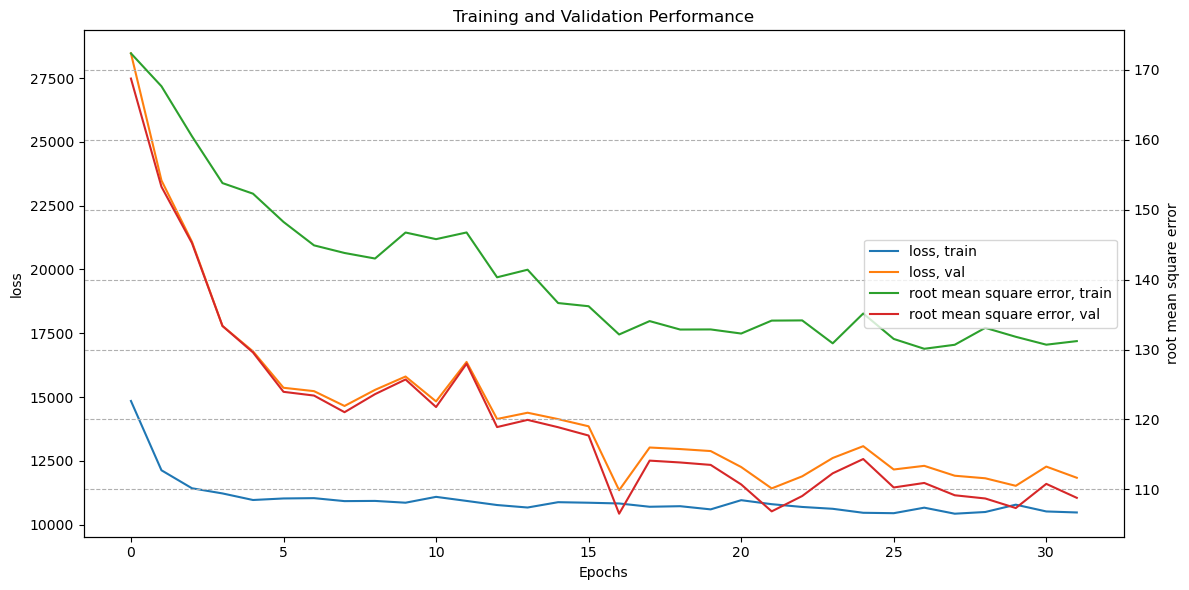

ploted
Running trial_1_lr0.0001_bs128_pat20_do0.0
epoch 0, train_loss 2.398e+04, val_loss 2.759e+04, train_rmse 233.5, val_rmse 166.1
epoch 1, train_loss 1.555e+04, val_loss 1.836e+04, train_rmse 220.5, val_rmse 135.5
epoch 2, train_loss 6.878e+03, val_loss 2.088e+04, train_rmse 258.0, val_rmse 144.5
EarlyStopping counter: 1/20
epoch 3, train_loss 5.229e+03, val_loss 2.356e+04, train_rmse 242.6, val_rmse 153.5
EarlyStopping counter: 2/20
epoch 4, train_loss 4.478e+03, val_loss 2.052e+04, train_rmse 204.6, val_rmse 143.3
EarlyStopping counter: 3/20
epoch 5, train_loss 3.986e+03, val_loss 1.787e+04, train_rmse 175.9, val_rmse 133.7
epoch 6, train_loss 3.762e+03, val_loss 1.631e+04, train_rmse 158.2, val_rmse 127.7
epoch 7, train_loss 3.676e+03, val_loss 1.533e+04, train_rmse 149.8, val_rmse 123.8
epoch 8, train_loss 3.609e+03, val_loss 1.443e+04, train_rmse 145.2, val_rmse 120.1
epoch 9, train_loss 3.616e+03, val_loss 1.378e+04, train_rmse 143.3, val_rmse 117.4
epoch 10, train_loss 3.662

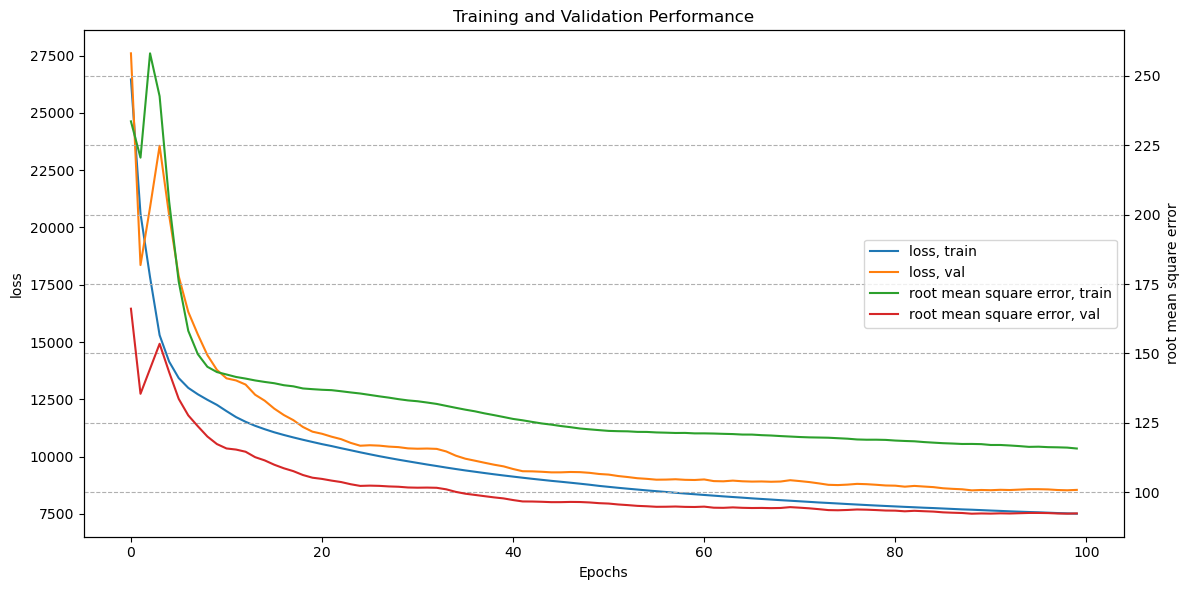

ploted
Running trial_2_lr0.001_bs256_pat15_do0.2
epoch 0, train_loss 2.028e+04, val_loss 2.530e+04, train_rmse 278.1, val_rmse 159.1
epoch 1, train_loss 1.781e+04, val_loss 1.447e+04, train_rmse 184.8, val_rmse 120.3
epoch 2, train_loss 1.805e+04, val_loss 1.363e+04, train_rmse 157.3, val_rmse 116.7
epoch 3, train_loss 2.592e+04, val_loss 1.421e+04, train_rmse 147.5, val_rmse 119.2
EarlyStopping counter: 1/15
epoch 4, train_loss 2.094e+04, val_loss 1.346e+04, train_rmse 136.9, val_rmse 116.0
epoch 5, train_loss 1.883e+04, val_loss 1.258e+04, train_rmse 133.3, val_rmse 112.2
epoch 6, train_loss 1.817e+04, val_loss 1.275e+04, train_rmse 134.8, val_rmse 112.9
EarlyStopping counter: 1/15
epoch 7, train_loss 2.163e+04, val_loss 1.216e+04, train_rmse 132.2, val_rmse 110.3
epoch 8, train_loss 2.231e+04, val_loss 1.179e+04, train_rmse 129.6, val_rmse 108.6
epoch 9, train_loss 1.541e+04, val_loss 1.212e+04, train_rmse 131.3, val_rmse 110.1
EarlyStopping counter: 1/15
epoch 10, train_loss 1.505e

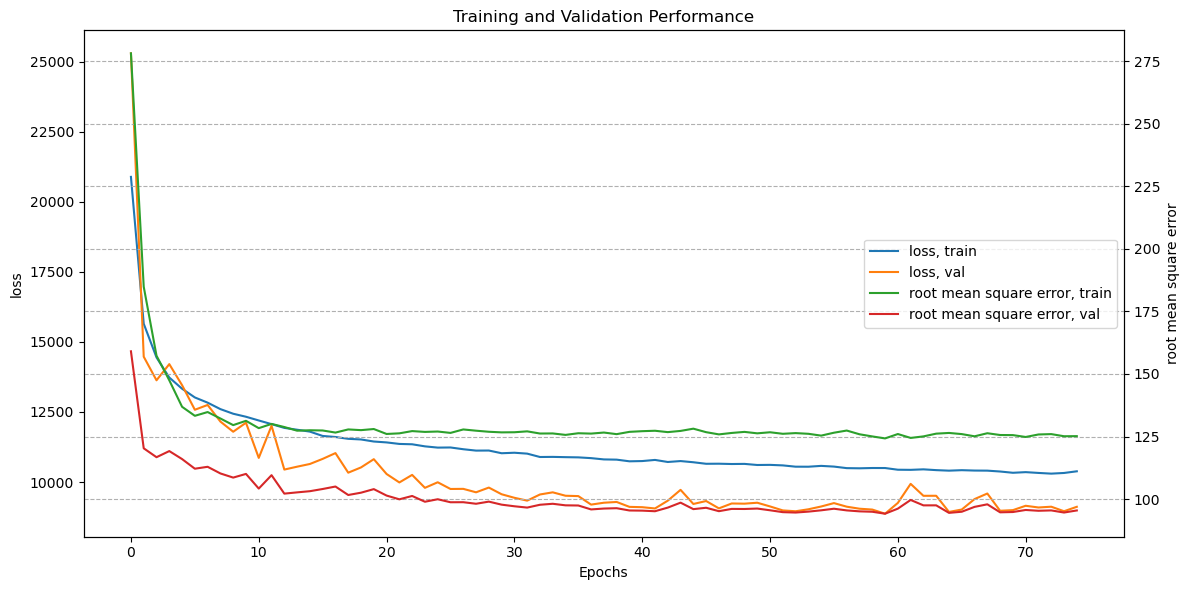

ploted
Running trial_3_lr0.001_bs256_pat20_do0.2
epoch 0, train_loss 2.711e+04, val_loss 3.682e+04, train_rmse 272.5, val_rmse 191.9
epoch 1, train_loss 1.708e+04, val_loss 1.572e+04, train_rmse 197.7, val_rmse 125.4
epoch 2, train_loss 1.742e+04, val_loss 1.386e+04, train_rmse 157.1, val_rmse 117.7
epoch 3, train_loss 1.748e+04, val_loss 1.299e+04, train_rmse 142.4, val_rmse 114.0
epoch 4, train_loss 1.787e+04, val_loss 1.293e+04, train_rmse 136.3, val_rmse 113.7
epoch 5, train_loss 1.578e+04, val_loss 1.199e+04, train_rmse 133.6, val_rmse 109.5
epoch 6, train_loss 1.802e+04, val_loss 1.134e+04, train_rmse 133.0, val_rmse 106.5
epoch 7, train_loss 1.813e+04, val_loss 1.205e+04, train_rmse 132.2, val_rmse 109.8
EarlyStopping counter: 1/20
epoch 8, train_loss 1.996e+04, val_loss 1.184e+04, train_rmse 132.1, val_rmse 108.8
EarlyStopping counter: 2/20
epoch 9, train_loss 1.933e+04, val_loss 1.150e+04, train_rmse 129.7, val_rmse 107.2
EarlyStopping counter: 3/20
epoch 10, train_loss 1.848e

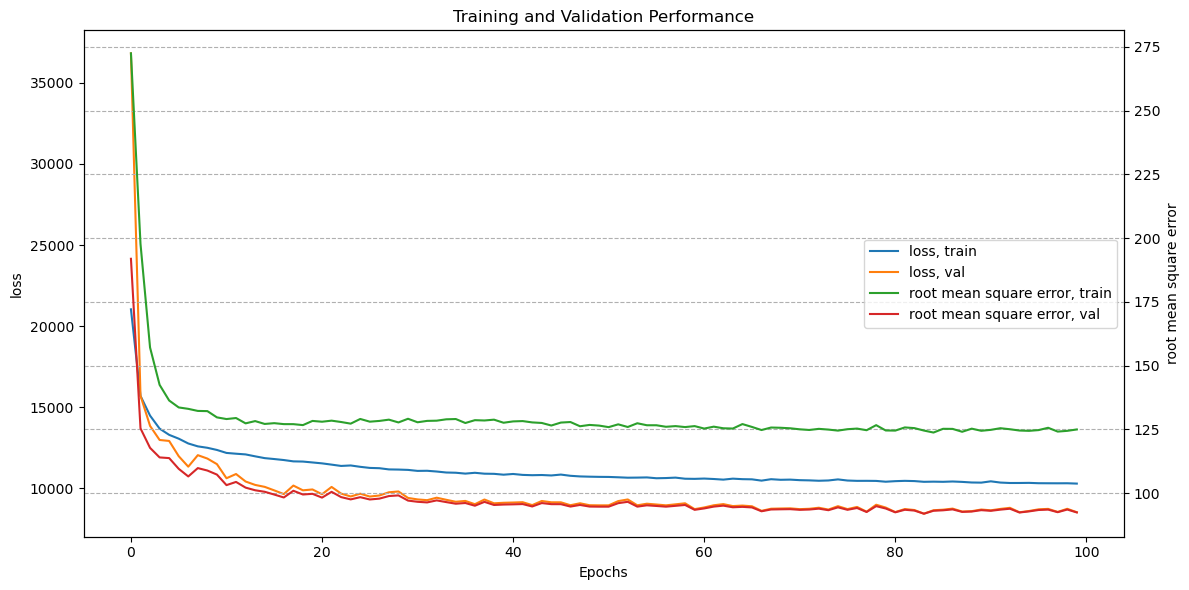

ploted
Running trial_4_lr0.001_bs64_pat15_do0.5
epoch 0, train_loss 6.663e+03, val_loss 2.286e+04, train_rmse 175.4, val_rmse 151.2
epoch 1, train_loss 8.782e+03, val_loss 2.579e+04, train_rmse 166.4, val_rmse 160.6
EarlyStopping counter: 1/15
epoch 2, train_loss 4.869e+03, val_loss 1.924e+04, train_rmse 156.4, val_rmse 138.7
epoch 3, train_loss 5.351e+03, val_loss 1.491e+04, train_rmse 144.1, val_rmse 122.1
epoch 4, train_loss 7.431e+03, val_loss 1.438e+04, train_rmse 148.1, val_rmse 119.9
epoch 5, train_loss 4.743e+03, val_loss 1.323e+04, train_rmse 146.0, val_rmse 115.0
epoch 6, train_loss 5.559e+03, val_loss 1.312e+04, train_rmse 145.8, val_rmse 114.5
epoch 7, train_loss 5.656e+03, val_loss 1.253e+04, train_rmse 145.4, val_rmse 111.9
epoch 8, train_loss 4.610e+03, val_loss 1.306e+04, train_rmse 146.7, val_rmse 114.3
EarlyStopping counter: 1/15
epoch 9, train_loss 4.155e+03, val_loss 1.294e+04, train_rmse 144.8, val_rmse 113.7
EarlyStopping counter: 2/15
epoch 10, train_loss 5.061e+

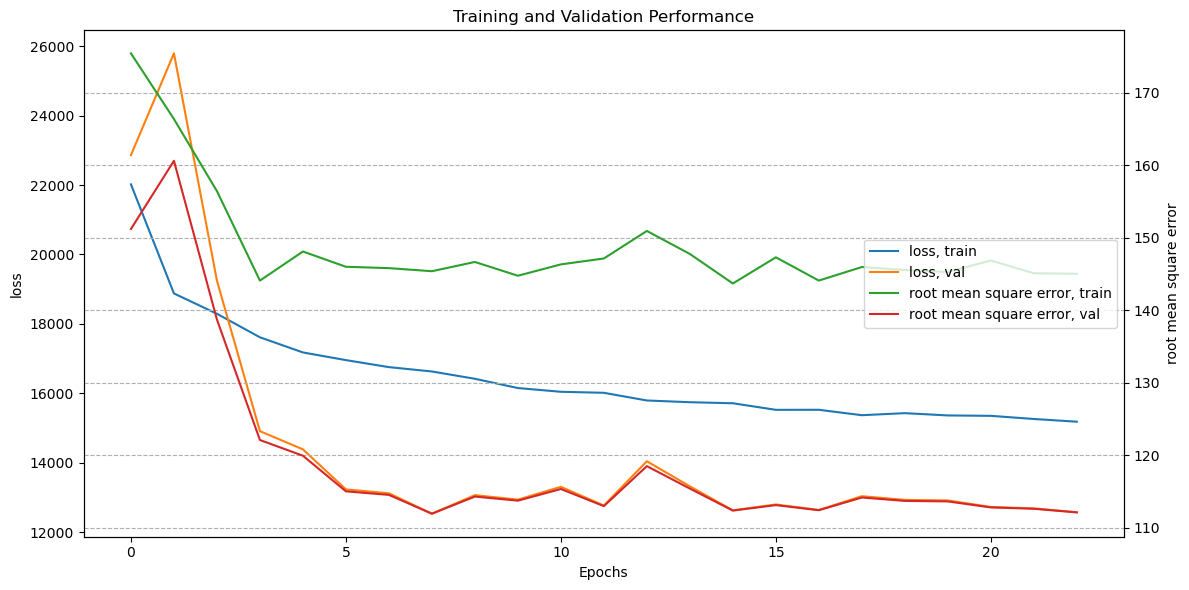

ploted
Running trial_5_lr0.0001_bs128_pat15_do0.0
epoch 0, train_loss 2.309e+04, val_loss 3.109e+04, train_rmse 241.4, val_rmse 176.3
epoch 1, train_loss 1.528e+04, val_loss 2.004e+04, train_rmse 242.7, val_rmse 141.6
epoch 2, train_loss 6.390e+03, val_loss 1.930e+04, train_rmse 294.1, val_rmse 138.9
epoch 3, train_loss 4.547e+03, val_loss 2.174e+04, train_rmse 303.5, val_rmse 147.4
EarlyStopping counter: 1/15
epoch 4, train_loss 4.145e+03, val_loss 1.858e+04, train_rmse 242.2, val_rmse 136.3
epoch 5, train_loss 3.547e+03, val_loss 1.787e+04, train_rmse 213.8, val_rmse 133.7
epoch 6, train_loss 3.391e+03, val_loss 1.705e+04, train_rmse 185.6, val_rmse 130.6
epoch 7, train_loss 3.422e+03, val_loss 1.603e+04, train_rmse 163.6, val_rmse 126.6
epoch 8, train_loss 3.542e+03, val_loss 1.506e+04, train_rmse 152.0, val_rmse 122.7
epoch 9, train_loss 3.567e+03, val_loss 1.434e+04, train_rmse 145.3, val_rmse 119.8
epoch 10, train_loss 3.565e+03, val_loss 1.384e+04, train_rmse 140.5, val_rmse 117

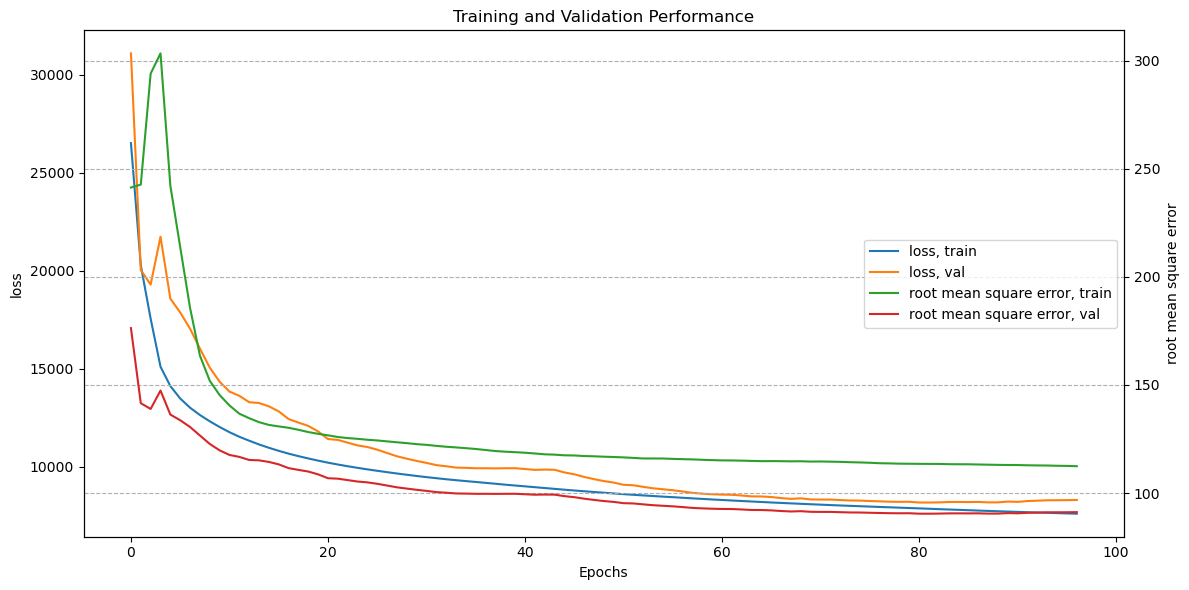

ploted
Running trial_6_lr0.001_bs256_pat20_do0.5
epoch 0, train_loss 2.728e+04, val_loss 2.619e+04, train_rmse 293.5, val_rmse 161.8
epoch 1, train_loss 2.986e+04, val_loss 2.176e+04, train_rmse 180.9, val_rmse 147.5
epoch 2, train_loss 2.154e+04, val_loss 1.502e+04, train_rmse 148.5, val_rmse 122.5
epoch 3, train_loss 2.455e+04, val_loss 1.478e+04, train_rmse 144.3, val_rmse 121.6
epoch 4, train_loss 1.941e+04, val_loss 1.262e+04, train_rmse 138.8, val_rmse 112.3
epoch 5, train_loss 2.347e+04, val_loss 1.283e+04, train_rmse 138.6, val_rmse 113.3
EarlyStopping counter: 1/20
epoch 6, train_loss 2.202e+04, val_loss 1.167e+04, train_rmse 135.6, val_rmse 108.0
epoch 7, train_loss 2.421e+04, val_loss 1.180e+04, train_rmse 134.6, val_rmse 108.6
EarlyStopping counter: 1/20
epoch 8, train_loss 2.324e+04, val_loss 1.213e+04, train_rmse 133.5, val_rmse 110.1
EarlyStopping counter: 2/20
epoch 9, train_loss 2.007e+04, val_loss 1.140e+04, train_rmse 132.8, val_rmse 106.8
epoch 10, train_loss 2.283e

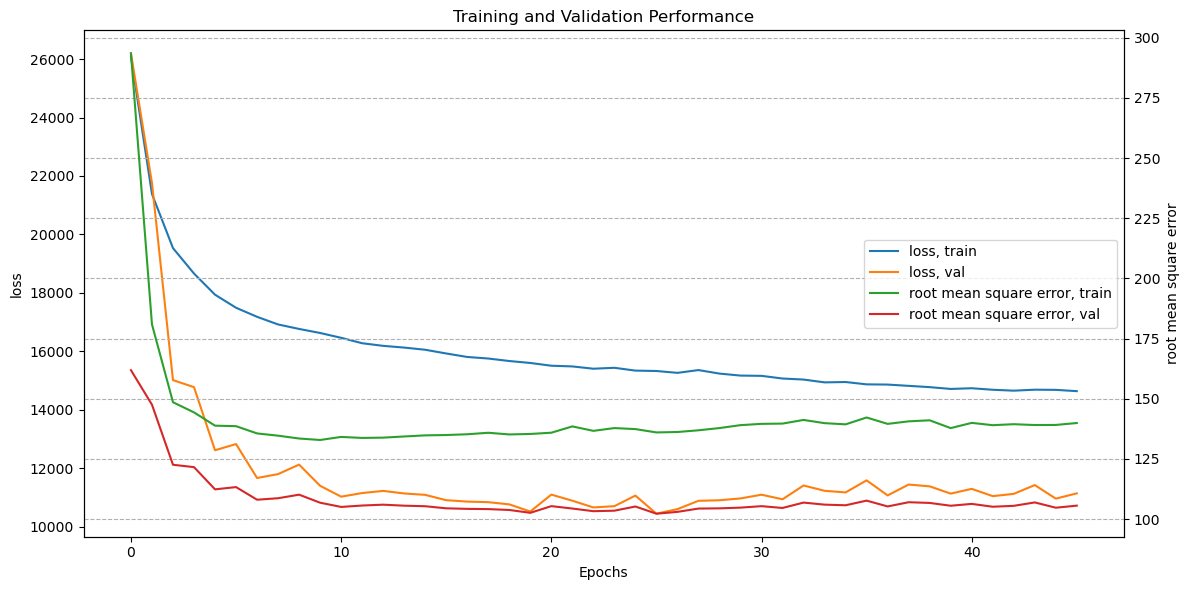

ploted
Running trial_7_lr0.0001_bs64_pat20_do0.5
epoch 0, train_loss 1.117e+04, val_loss 3.133e+04, train_rmse 214.4, val_rmse 177.0
epoch 1, train_loss 5.975e+03, val_loss 1.837e+04, train_rmse 217.3, val_rmse 135.5
epoch 2, train_loss 6.590e+03, val_loss 1.457e+04, train_rmse 272.2, val_rmse 120.7
epoch 3, train_loss 5.671e+03, val_loss 1.401e+04, train_rmse 218.0, val_rmse 118.4
epoch 4, train_loss 5.676e+03, val_loss 1.506e+04, train_rmse 189.6, val_rmse 122.7
EarlyStopping counter: 1/20
epoch 5, train_loss 6.666e+03, val_loss 1.453e+04, train_rmse 163.0, val_rmse 120.6
EarlyStopping counter: 2/20
epoch 6, train_loss 5.516e+03, val_loss 1.330e+04, train_rmse 147.8, val_rmse 115.3
epoch 7, train_loss 6.377e+03, val_loss 1.304e+04, train_rmse 143.3, val_rmse 114.2
epoch 8, train_loss 5.456e+03, val_loss 1.328e+04, train_rmse 139.8, val_rmse 115.2
EarlyStopping counter: 1/20
epoch 9, train_loss 4.977e+03, val_loss 1.411e+04, train_rmse 140.0, val_rmse 118.8
EarlyStopping counter: 2/20

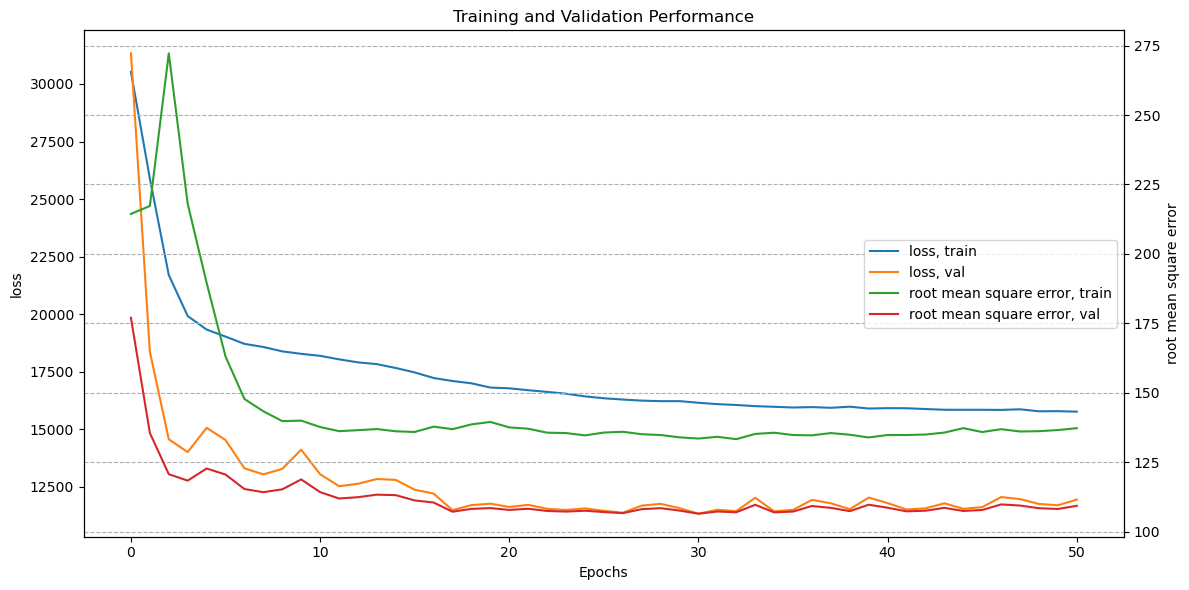

ploted
Running trial_8_lr0.01_bs128_pat10_do0.0
epoch 0, train_loss 5.964e+03, val_loss 3.124e+04, train_rmse 169.6, val_rmse 176.8
epoch 1, train_loss 4.216e+03, val_loss 2.661e+04, train_rmse 160.0, val_rmse 163.1
epoch 2, train_loss 5.269e+03, val_loss 2.173e+04, train_rmse 151.0, val_rmse 147.4
epoch 3, train_loss 5.231e+03, val_loss 2.079e+04, train_rmse 149.5, val_rmse 144.2
epoch 4, train_loss 5.312e+03, val_loss 2.103e+04, train_rmse 149.7, val_rmse 145.0
EarlyStopping counter: 1/10
epoch 5, train_loss 4.914e+03, val_loss 1.909e+04, train_rmse 150.7, val_rmse 138.2
epoch 6, train_loss 4.573e+03, val_loss 1.885e+04, train_rmse 148.0, val_rmse 137.3
epoch 7, train_loss 4.301e+03, val_loss 1.701e+04, train_rmse 144.2, val_rmse 130.4
epoch 8, train_loss 4.732e+03, val_loss 1.612e+04, train_rmse 142.7, val_rmse 127.0
epoch 9, train_loss 4.663e+03, val_loss 1.670e+04, train_rmse 144.0, val_rmse 129.2
EarlyStopping counter: 1/10
epoch 10, train_loss 4.845e+03, val_loss 1.597e+04, trai

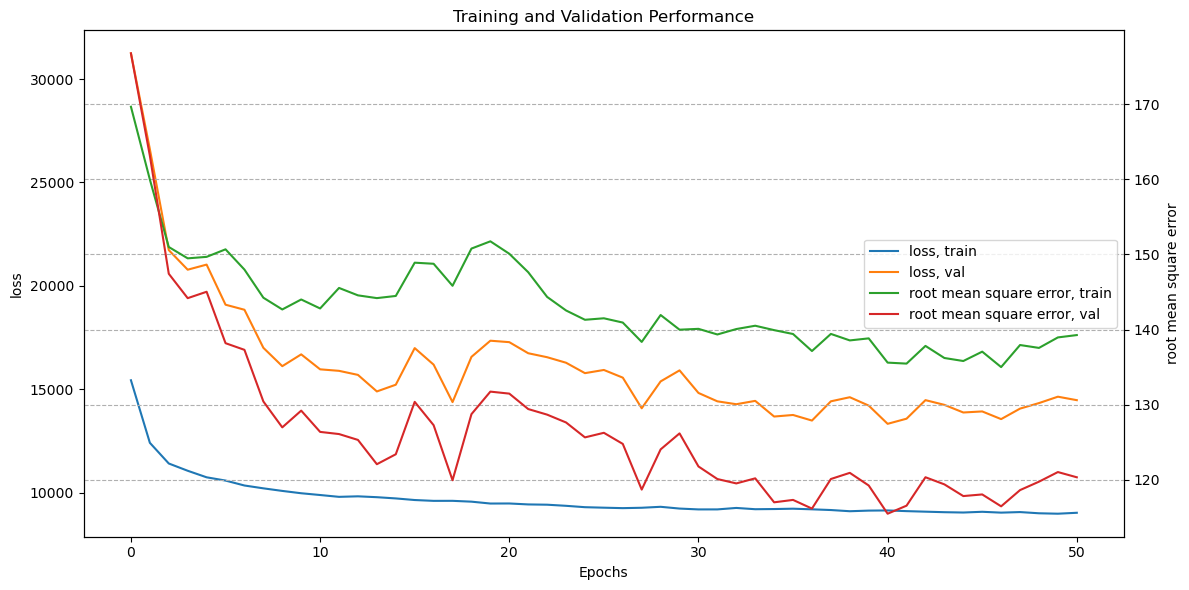

ploted
Running trial_9_lr0.001_bs64_pat15_do0.0
epoch 0, train_loss 2.303e+03, val_loss 2.758e+04, train_rmse 184.1, val_rmse 166.1
epoch 1, train_loss 2.497e+03, val_loss 2.316e+04, train_rmse 156.9, val_rmse 152.2
epoch 2, train_loss 2.369e+03, val_loss 2.277e+04, train_rmse 152.2, val_rmse 150.9
epoch 3, train_loss 2.210e+03, val_loss 1.934e+04, train_rmse 144.5, val_rmse 139.1
epoch 4, train_loss 2.007e+03, val_loss 1.780e+04, train_rmse 141.3, val_rmse 133.4
epoch 5, train_loss 1.858e+03, val_loss 1.570e+04, train_rmse 137.2, val_rmse 125.3
epoch 6, train_loss 1.815e+03, val_loss 1.448e+04, train_rmse 134.8, val_rmse 120.3
epoch 7, train_loss 2.028e+03, val_loss 1.396e+04, train_rmse 134.7, val_rmse 118.2
epoch 8, train_loss 1.895e+03, val_loss 1.321e+04, train_rmse 132.1, val_rmse 114.9
epoch 9, train_loss 2.224e+03, val_loss 1.296e+04, train_rmse 131.8, val_rmse 113.8
epoch 10, train_loss 2.018e+03, val_loss 1.227e+04, train_rmse 129.6, val_rmse 110.8
epoch 11, train_loss 2.172e

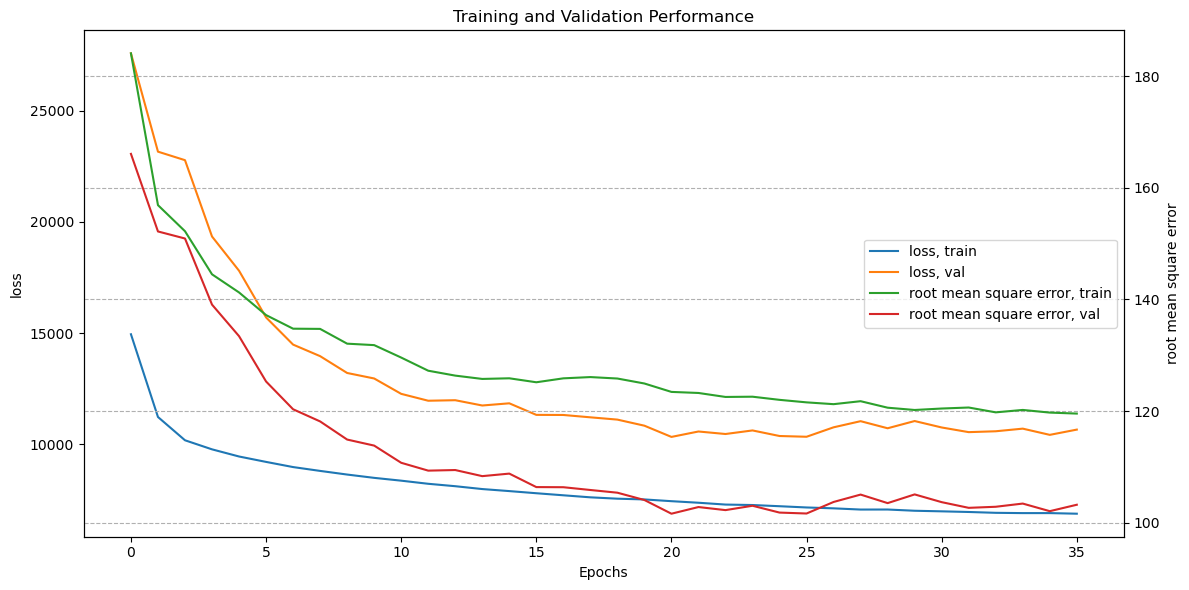

ploted
Running trial_10_lr0.01_bs256_pat15_do0.5
epoch 0, train_loss 4.020e+04, val_loss 1.888e+04, train_rmse 153.8, val_rmse 137.4
epoch 1, train_loss 2.792e+04, val_loss 1.817e+04, train_rmse 159.5, val_rmse 134.8
epoch 2, train_loss 4.071e+04, val_loss 1.825e+04, train_rmse 161.7, val_rmse 135.1
EarlyStopping counter: 1/15
epoch 3, train_loss 2.087e+04, val_loss 1.773e+04, train_rmse 158.5, val_rmse 133.1
epoch 4, train_loss 2.501e+04, val_loss 1.730e+04, train_rmse 161.6, val_rmse 131.5
epoch 5, train_loss 2.106e+04, val_loss 1.814e+04, train_rmse 163.0, val_rmse 134.7
EarlyStopping counter: 1/15
epoch 6, train_loss 2.036e+04, val_loss 1.666e+04, train_rmse 160.1, val_rmse 129.1
epoch 7, train_loss 2.677e+04, val_loss 1.786e+04, train_rmse 163.4, val_rmse 133.6
EarlyStopping counter: 1/15
epoch 8, train_loss 3.461e+04, val_loss 1.765e+04, train_rmse 161.3, val_rmse 132.9
EarlyStopping counter: 2/15
epoch 9, train_loss 2.438e+04, val_loss 1.680e+04, train_rmse 159.2, val_rmse 129.6

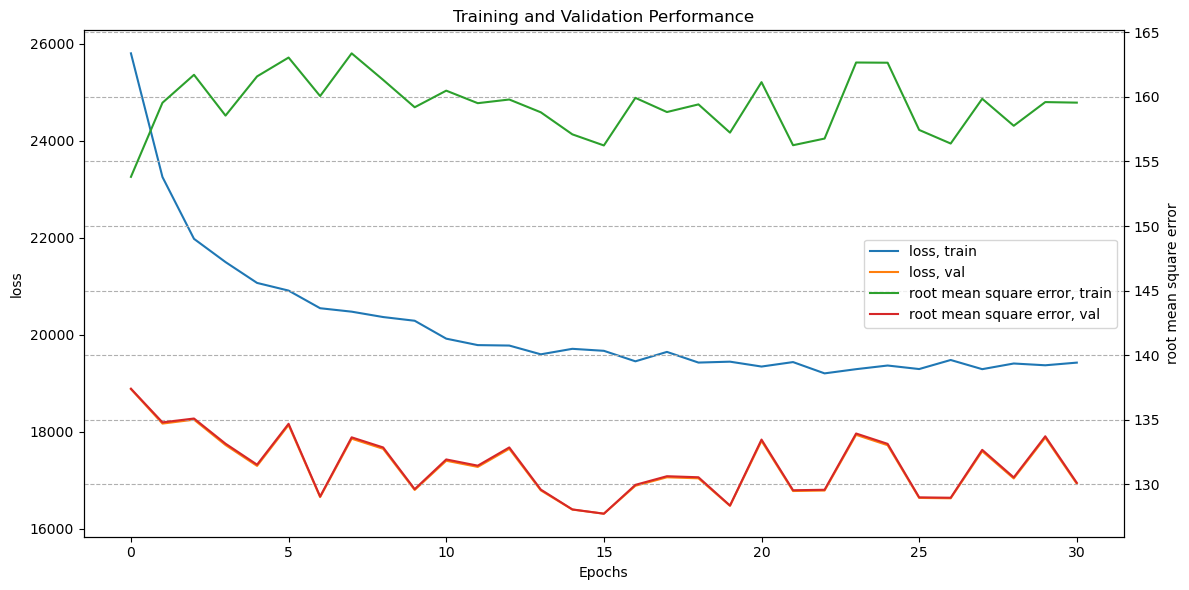

ploted
Running trial_11_lr0.001_bs256_pat15_do0.5
epoch 0, train_loss 2.228e+04, val_loss 2.533e+04, train_rmse 306.4, val_rmse 159.2
epoch 1, train_loss 2.425e+04, val_loss 1.674e+04, train_rmse 166.9, val_rmse 129.4
epoch 2, train_loss 3.224e+04, val_loss 1.414e+04, train_rmse 147.3, val_rmse 118.9
epoch 3, train_loss 2.899e+04, val_loss 1.427e+04, train_rmse 140.8, val_rmse 119.5
EarlyStopping counter: 1/15
epoch 4, train_loss 2.271e+04, val_loss 1.320e+04, train_rmse 136.7, val_rmse 114.9
epoch 5, train_loss 2.198e+04, val_loss 1.270e+04, train_rmse 135.7, val_rmse 112.7
epoch 6, train_loss 2.865e+04, val_loss 1.237e+04, train_rmse 134.6, val_rmse 111.2
epoch 7, train_loss 2.127e+04, val_loss 1.253e+04, train_rmse 133.1, val_rmse 112.0
EarlyStopping counter: 1/15
epoch 8, train_loss 2.288e+04, val_loss 1.154e+04, train_rmse 133.9, val_rmse 107.4
epoch 9, train_loss 1.885e+04, val_loss 1.214e+04, train_rmse 133.8, val_rmse 110.2
EarlyStopping counter: 1/15
epoch 10, train_loss 1.927

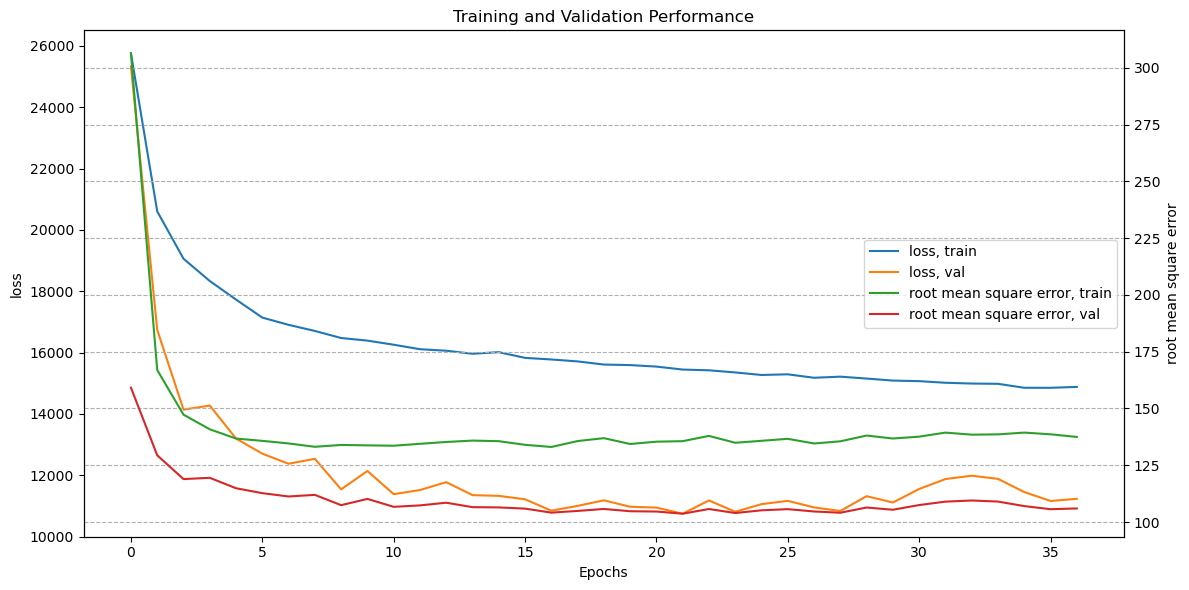

ploted
Running trial_12_lr0.001_bs128_pat10_do0.0
epoch 0, train_loss 4.197e+03, val_loss 3.904e+04, train_rmse 197.6, val_rmse 197.6
epoch 1, train_loss 4.330e+03, val_loss 2.605e+04, train_rmse 152.1, val_rmse 161.4
epoch 2, train_loss 5.015e+03, val_loss 2.554e+04, train_rmse 151.2, val_rmse 159.8
epoch 3, train_loss 4.104e+03, val_loss 2.246e+04, train_rmse 145.2, val_rmse 149.9
epoch 4, train_loss 3.623e+03, val_loss 1.931e+04, train_rmse 140.0, val_rmse 138.9
epoch 5, train_loss 3.259e+03, val_loss 1.709e+04, train_rmse 135.3, val_rmse 130.7
epoch 6, train_loss 3.176e+03, val_loss 1.585e+04, train_rmse 132.5, val_rmse 125.9
epoch 7, train_loss 3.242e+03, val_loss 1.445e+04, train_rmse 131.0, val_rmse 120.2
epoch 8, train_loss 3.107e+03, val_loss 1.397e+04, train_rmse 129.7, val_rmse 118.2
epoch 9, train_loss 3.068e+03, val_loss 1.346e+04, train_rmse 128.0, val_rmse 116.0
epoch 10, train_loss 3.031e+03, val_loss 1.339e+04, train_rmse 128.0, val_rmse 115.7
epoch 11, train_loss 2.90

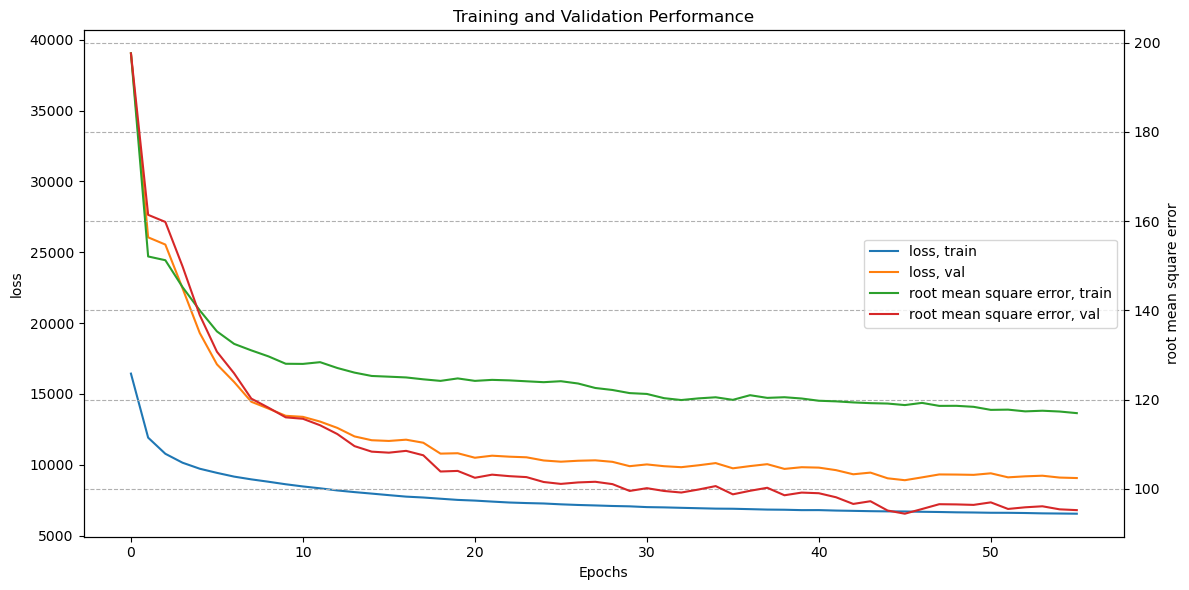

ploted
Running trial_13_lr0.01_bs128_pat20_do0.2
epoch 0, train_loss 7.192e+03, val_loss 2.055e+04, train_rmse 160.5, val_rmse 143.4
epoch 1, train_loss 1.002e+04, val_loss 1.795e+04, train_rmse 157.0, val_rmse 134.0
epoch 2, train_loss 2.646e+04, val_loss 1.851e+04, train_rmse 157.3, val_rmse 136.1
EarlyStopping counter: 1/20
epoch 3, train_loss 7.091e+03, val_loss 1.996e+04, train_rmse 156.7, val_rmse 141.3
EarlyStopping counter: 2/20
epoch 4, train_loss 7.255e+03, val_loss 1.792e+04, train_rmse 156.6, val_rmse 133.9
epoch 5, train_loss 9.644e+03, val_loss 1.947e+04, train_rmse 159.7, val_rmse 139.5
EarlyStopping counter: 1/20
epoch 6, train_loss 1.216e+04, val_loss 1.829e+04, train_rmse 160.2, val_rmse 135.3
EarlyStopping counter: 2/20
epoch 7, train_loss 9.260e+03, val_loss 1.657e+04, train_rmse 156.6, val_rmse 128.7
epoch 8, train_loss 1.289e+04, val_loss 1.684e+04, train_rmse 155.7, val_rmse 129.8
EarlyStopping counter: 1/20
epoch 9, train_loss 9.711e+03, val_loss 1.735e+04, trai

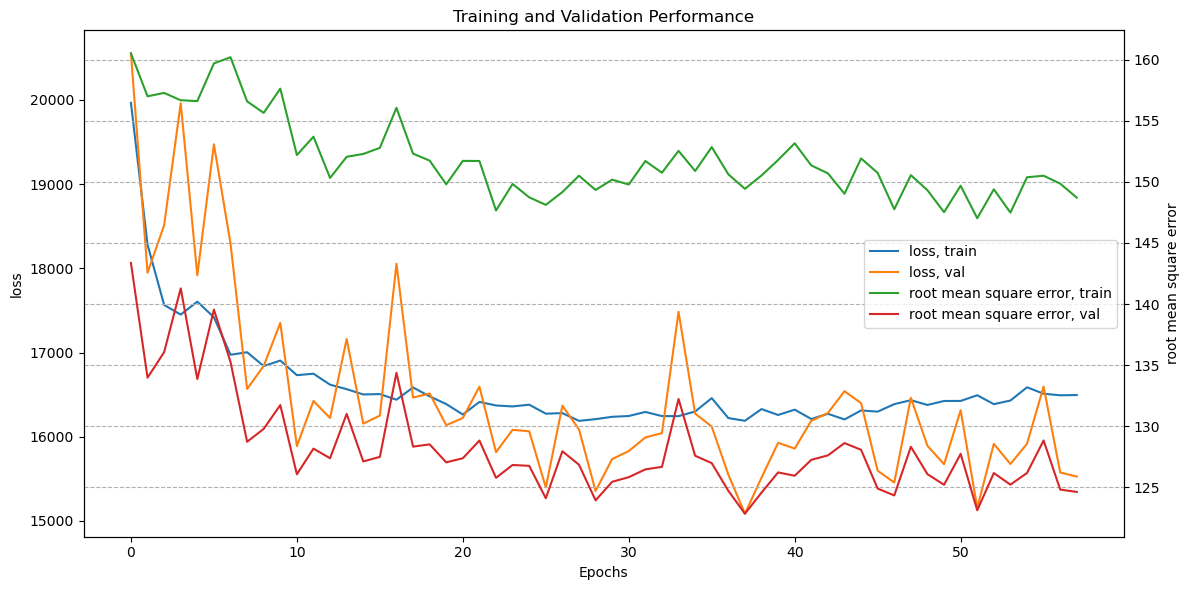

ploted
Running trial_14_lr0.0001_bs256_pat15_do0.5
epoch 0, train_loss 5.281e+04, val_loss 3.516e+04, train_rmse 219.5, val_rmse 187.5
epoch 1, train_loss 4.683e+04, val_loss 2.223e+04, train_rmse 186.9, val_rmse 149.1
epoch 2, train_loss 4.558e+04, val_loss 1.924e+04, train_rmse 177.3, val_rmse 138.7
epoch 3, train_loss 4.470e+04, val_loss 1.696e+04, train_rmse 172.9, val_rmse 130.2
epoch 4, train_loss 3.062e+04, val_loss 1.525e+04, train_rmse 179.8, val_rmse 123.5
epoch 5, train_loss 3.356e+04, val_loss 1.400e+04, train_rmse 204.4, val_rmse 118.3
epoch 6, train_loss 2.507e+04, val_loss 1.315e+04, train_rmse 229.3, val_rmse 114.7
epoch 7, train_loss 3.086e+04, val_loss 1.253e+04, train_rmse 216.0, val_rmse 111.9
epoch 8, train_loss 2.350e+04, val_loss 1.205e+04, train_rmse 195.2, val_rmse 109.8
epoch 9, train_loss 3.119e+04, val_loss 1.183e+04, train_rmse 178.4, val_rmse 108.8
epoch 10, train_loss 2.668e+04, val_loss 1.175e+04, train_rmse 161.8, val_rmse 108.4
epoch 11, train_loss 2.0

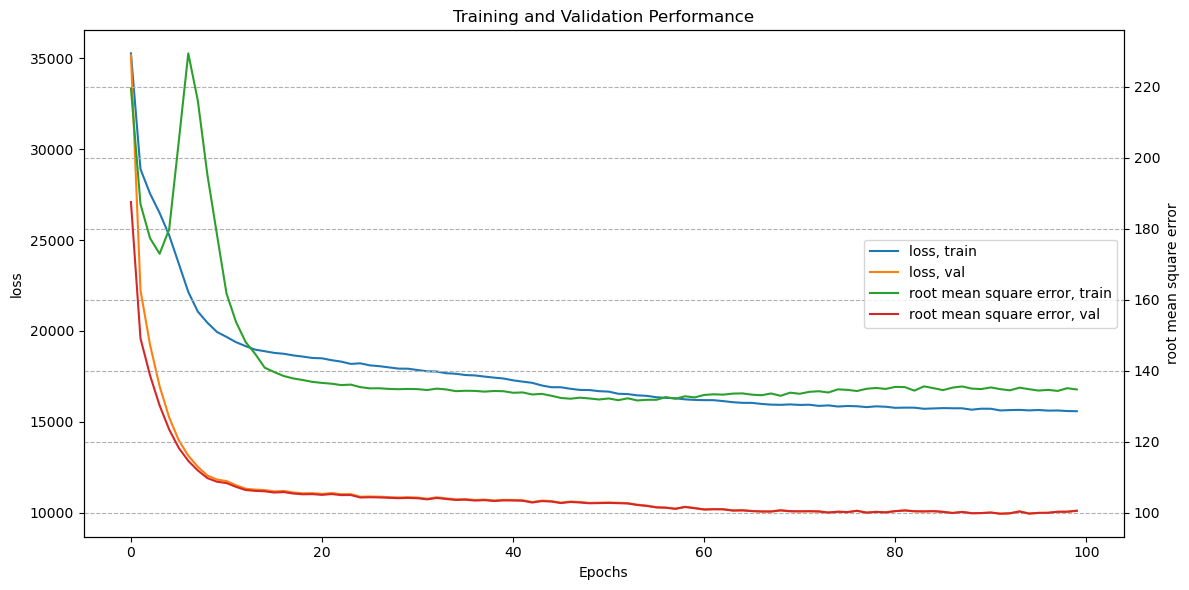

ploted
Running trial_15_lr0.01_bs128_pat10_do0.5
epoch 0, train_loss 3.541e+04, val_loss 2.410e+04, train_rmse 175.8, val_rmse 155.2
epoch 1, train_loss 2.849e+04, val_loss 1.994e+04, train_rmse 168.0, val_rmse 141.2
epoch 2, train_loss 1.400e+04, val_loss 2.208e+04, train_rmse 167.8, val_rmse 148.6
EarlyStopping counter: 1/10
epoch 3, train_loss 1.283e+04, val_loss 1.798e+04, train_rmse 161.0, val_rmse 134.1
epoch 4, train_loss 1.005e+04, val_loss 1.739e+04, train_rmse 159.4, val_rmse 131.9
epoch 5, train_loss 1.331e+04, val_loss 1.998e+04, train_rmse 164.5, val_rmse 141.3
EarlyStopping counter: 1/10
epoch 6, train_loss 1.662e+04, val_loss 1.724e+04, train_rmse 160.5, val_rmse 131.3
epoch 7, train_loss 1.470e+04, val_loss 1.836e+04, train_rmse 163.4, val_rmse 135.5
EarlyStopping counter: 1/10
epoch 8, train_loss 1.181e+04, val_loss 1.796e+04, train_rmse 161.8, val_rmse 134.0
EarlyStopping counter: 2/10
epoch 9, train_loss 1.217e+04, val_loss 1.724e+04, train_rmse 160.4, val_rmse 131.3

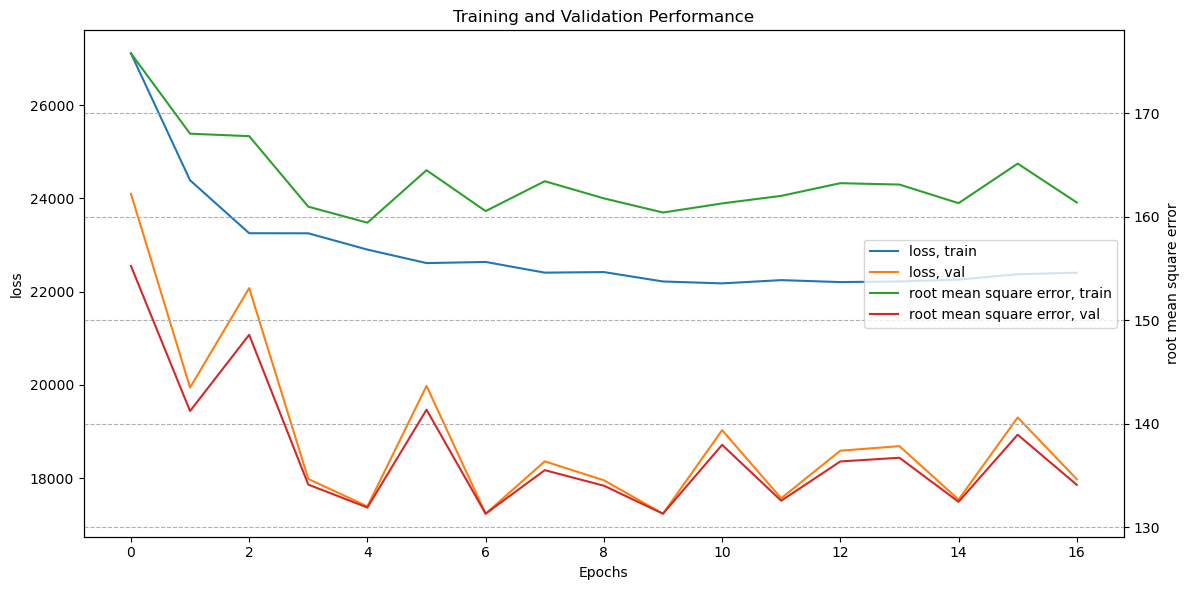

ploted
Running trial_16_lr0.01_bs64_pat10_do0.5
epoch 0, train_loss 1.019e+04, val_loss 2.448e+04, train_rmse 174.1, val_rmse 156.5
epoch 1, train_loss 8.245e+03, val_loss 2.175e+04, train_rmse 170.7, val_rmse 147.5
epoch 2, train_loss 7.867e+03, val_loss 2.246e+04, train_rmse 170.4, val_rmse 149.9
EarlyStopping counter: 1/10
epoch 3, train_loss 1.092e+04, val_loss 1.908e+04, train_rmse 166.7, val_rmse 138.1
epoch 4, train_loss 7.196e+03, val_loss 2.000e+04, train_rmse 169.2, val_rmse 141.4
EarlyStopping counter: 1/10
epoch 5, train_loss 7.205e+03, val_loss 1.964e+04, train_rmse 171.7, val_rmse 140.1
EarlyStopping counter: 2/10
epoch 6, train_loss 1.320e+04, val_loss 1.990e+04, train_rmse 168.3, val_rmse 141.1
EarlyStopping counter: 3/10
epoch 7, train_loss 7.004e+03, val_loss 1.916e+04, train_rmse 169.3, val_rmse 138.4
EarlyStopping counter: 4/10
epoch 8, train_loss 4.704e+03, val_loss 1.943e+04, train_rmse 170.7, val_rmse 139.4
EarlyStopping counter: 5/10
epoch 9, train_loss 5.929e+0

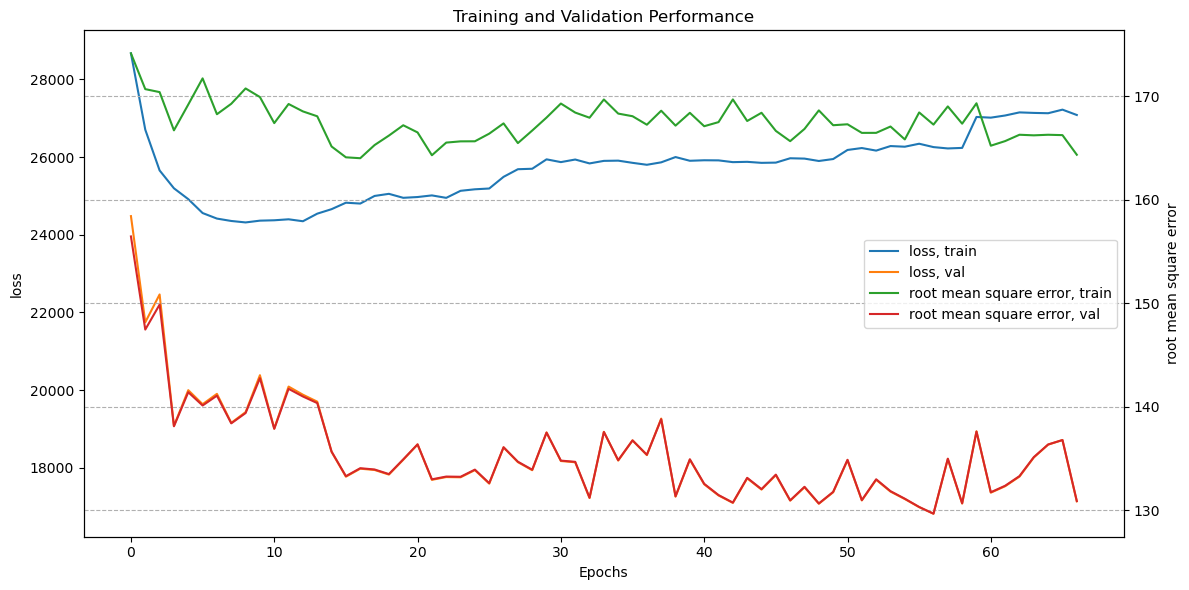

ploted
Running trial_17_lr0.001_bs128_pat20_do0.2
epoch 0, train_loss 5.338e+03, val_loss 1.678e+04, train_rmse 181.8, val_rmse 129.5
epoch 1, train_loss 5.279e+03, val_loss 1.815e+04, train_rmse 165.1, val_rmse 134.7
EarlyStopping counter: 1/20
epoch 2, train_loss 4.710e+03, val_loss 1.569e+04, train_rmse 144.7, val_rmse 125.2
epoch 3, train_loss 7.757e+03, val_loss 1.265e+04, train_rmse 138.4, val_rmse 112.5
epoch 4, train_loss 7.149e+03, val_loss 1.344e+04, train_rmse 137.5, val_rmse 115.9
EarlyStopping counter: 1/20
epoch 5, train_loss 4.563e+03, val_loss 1.224e+04, train_rmse 134.0, val_rmse 110.6
epoch 6, train_loss 4.981e+03, val_loss 1.277e+04, train_rmse 136.2, val_rmse 113.0
EarlyStopping counter: 1/20
epoch 7, train_loss 5.056e+03, val_loss 1.192e+04, train_rmse 132.4, val_rmse 109.2
epoch 8, train_loss 6.297e+03, val_loss 1.203e+04, train_rmse 134.7, val_rmse 109.7
EarlyStopping counter: 1/20
epoch 9, train_loss 5.618e+03, val_loss 1.103e+04, train_rmse 134.2, val_rmse 105.

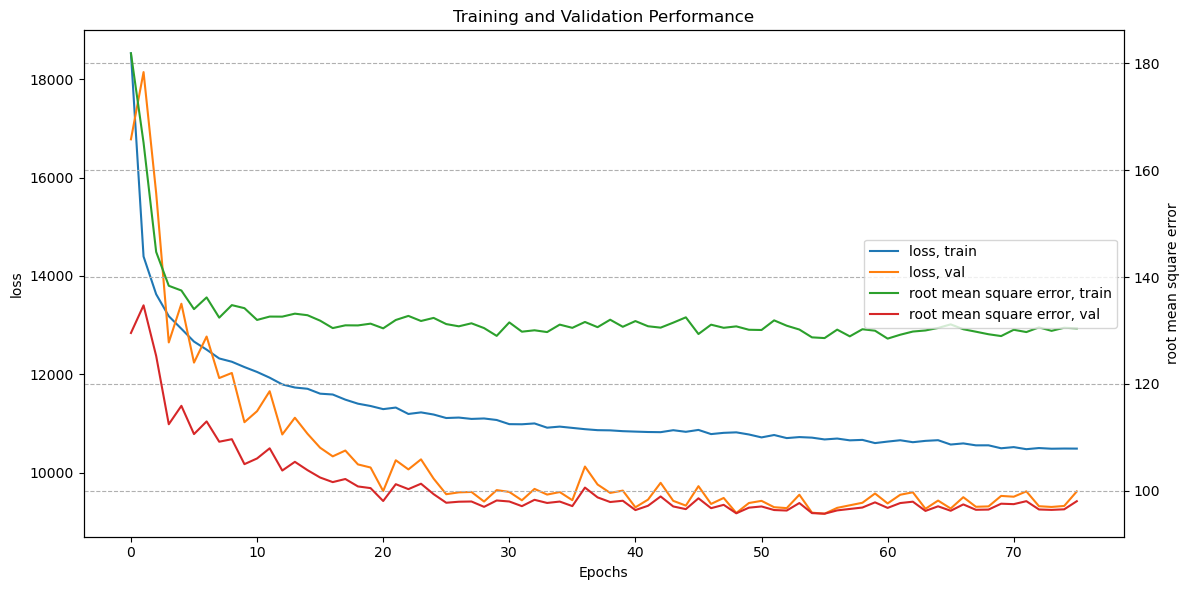

ploted
Running trial_18_lr0.01_bs64_pat15_do0.5
epoch 0, train_loss 1.310e+04, val_loss 2.152e+04, train_rmse 171.0, val_rmse 146.7
epoch 1, train_loss 7.928e+03, val_loss 2.102e+04, train_rmse 170.6, val_rmse 145.0
epoch 2, train_loss 1.150e+04, val_loss 2.025e+04, train_rmse 168.5, val_rmse 142.3
epoch 3, train_loss 1.032e+04, val_loss 2.115e+04, train_rmse 170.3, val_rmse 145.4
EarlyStopping counter: 1/15
epoch 4, train_loss 1.117e+04, val_loss 2.004e+04, train_rmse 166.7, val_rmse 141.6
epoch 5, train_loss 9.174e+03, val_loss 2.042e+04, train_rmse 168.7, val_rmse 142.9
EarlyStopping counter: 1/15
epoch 6, train_loss 1.033e+04, val_loss 2.035e+04, train_rmse 168.6, val_rmse 142.6
EarlyStopping counter: 2/15
epoch 7, train_loss 7.928e+03, val_loss 2.017e+04, train_rmse 168.6, val_rmse 142.0
EarlyStopping counter: 3/15
epoch 8, train_loss 9.136e+03, val_loss 1.946e+04, train_rmse 168.7, val_rmse 139.5
epoch 9, train_loss 9.901e+03, val_loss 1.956e+04, train_rmse 168.4, val_rmse 139.9


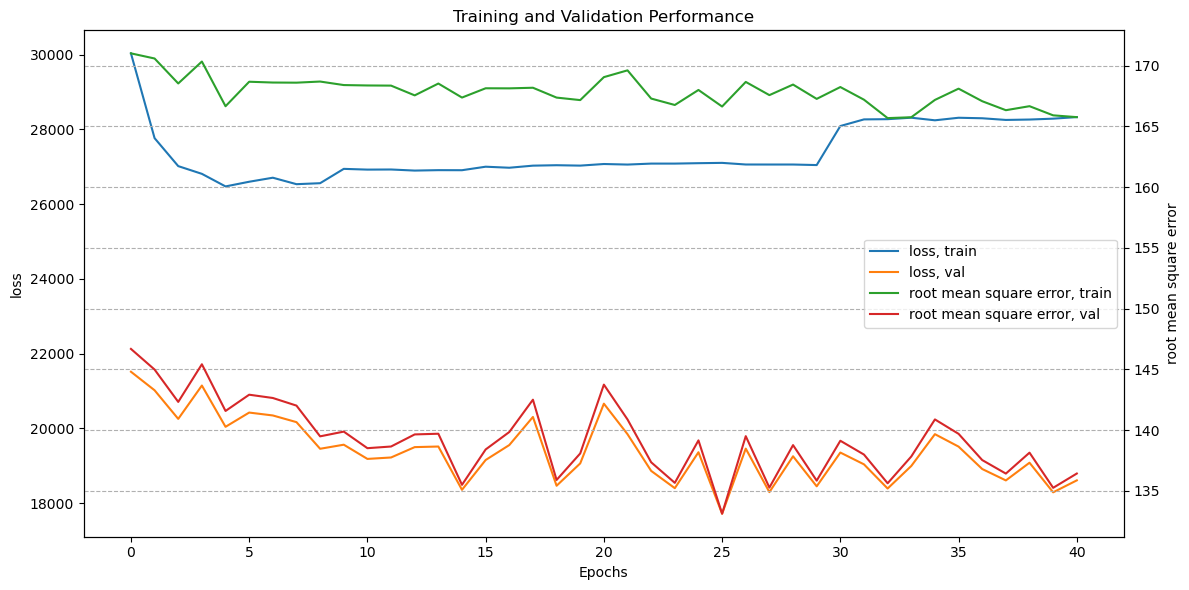

ploted
Running trial_19_lr0.001_bs64_pat20_do0.0
epoch 0, train_loss 2.199e+03, val_loss 3.506e+04, train_rmse 206.9, val_rmse 187.2
epoch 1, train_loss 2.432e+03, val_loss 2.366e+04, train_rmse 162.6, val_rmse 153.8
epoch 2, train_loss 2.522e+03, val_loss 2.242e+04, train_rmse 153.0, val_rmse 149.7
epoch 3, train_loss 2.722e+03, val_loss 2.029e+04, train_rmse 149.4, val_rmse 142.4
epoch 4, train_loss 2.443e+03, val_loss 1.963e+04, train_rmse 146.5, val_rmse 140.1
epoch 5, train_loss 2.217e+03, val_loss 1.813e+04, train_rmse 142.3, val_rmse 134.6
epoch 6, train_loss 2.079e+03, val_loss 1.685e+04, train_rmse 138.6, val_rmse 129.8
epoch 7, train_loss 2.161e+03, val_loss 1.632e+04, train_rmse 135.7, val_rmse 127.7
epoch 8, train_loss 2.345e+03, val_loss 1.572e+04, train_rmse 134.6, val_rmse 125.4
epoch 9, train_loss 2.428e+03, val_loss 1.516e+04, train_rmse 134.4, val_rmse 123.1
epoch 10, train_loss 2.738e+03, val_loss 1.384e+04, train_rmse 132.6, val_rmse 117.6
epoch 11, train_loss 2.409

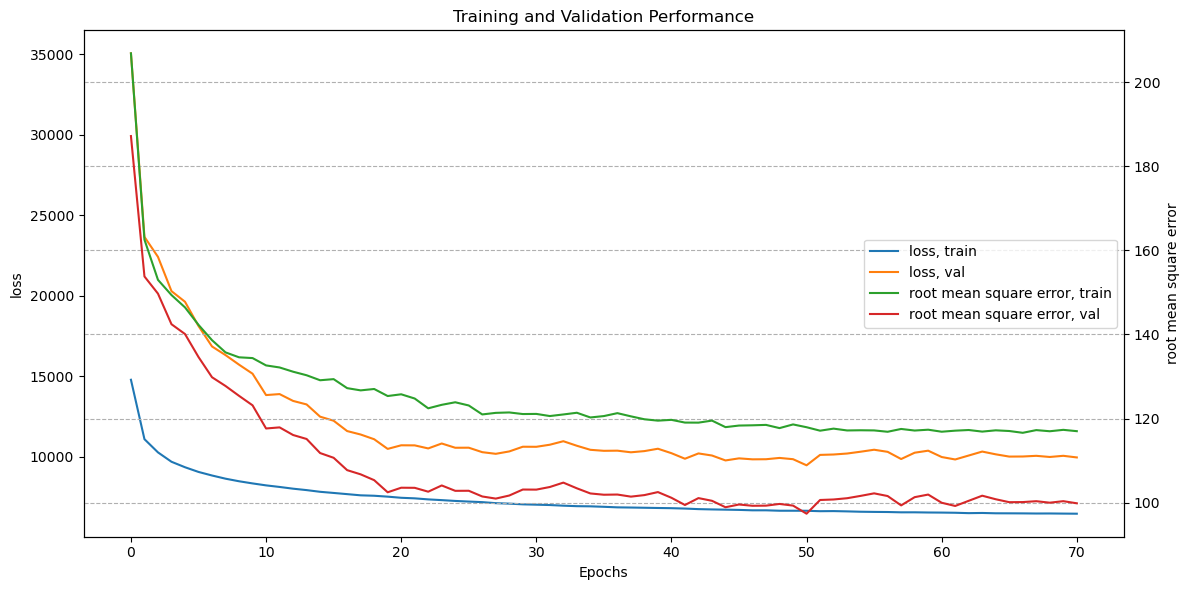

ploted


In [46]:
learning_rates = [1e-4, 1e-3, 1e-2]
batch_sizes = [64, 128, 256]
patiences = [10, 15, 20]
dropouts = [0.0, 0.2, 0.5]

all_combinations = list(product(learning_rates, batch_sizes, patiences, dropouts))

# Shuffle and pick without replacement
random.seed(42)
random.shuffle(all_combinations)

all_results, model_params = perform_random_search(
    all_combinations,
    num_trials=20
)

In [50]:
from tabulate import tabulate

def create_summary_table(all_results, model_params):
    table_data = []

    for config_name, results in all_results.items():
        params = model_params[config_name]
        train_rmse = results['train_rmse'][-1]
        val_rmse = results['val_rmse'][-1]
        test_rmse = results['test_rmse'][-1] if 'test_rmse' in results else "N/A"
        test_mae = results['test_mae'][-1] if 'test_mae' in results else "N/A"
        test_r2 = results['test_r2'][-1] if 'test_r2' in results else "N/A"

        table_data.append([
            f"lr={params['lr']}, bs={params['batch_size']}, pat={params['patience']}, do={params['dropout']}",
            train_rmse,
            val_rmse,
            test_rmse,
            test_mae,
            test_r2,
        ])

    # Sort by validation RMSE (index 2 in table_data rows)
    table_data.sort(key=lambda x: x[2])  # Lower RMSE is better

    # Format for printing
    table_data_formatted = [
        [
            row[0],
            f"{row[1]:.4f}",
            f"{row[2]:.4f}",
            f"{row[3]:.4f}" if isinstance(row[3], float) else row[3],
            f"{row[4]:.4f}" if isinstance(row[4], float) else row[4],
            f"{row[5]:.4f}" if isinstance(row[5], float) else row[5],
        ] for row in table_data
    ]

    headers = ["Parameters", "Train RMSE", "Val RMSE", "Test RMSE", "Test MAE", "Test R2"]
    print(tabulate(table_data_formatted, headers=headers, tablefmt="grid"))


In [51]:
create_summary_table(all_results, model_params)

+-----------------------------------+--------------+------------+-------------+------------+-----------+
| Parameters                        |   Train RMSE |   Val RMSE |   Test RMSE |   Test MAE |   Test R2 |
+===================================+==============+============+=============+============+===========+
| lr=0.0001, bs=128, pat=15, do=0.0 |      112.414 |    91.1568 |     136.636 |   100.002  |    0.1508 |
+-----------------------------------+--------------+------------+-------------+------------+-----------+
| lr=0.001, bs=256, pat=20, do=0.2  |      124.934 |    92.3819 |     143.255 |   109.573  |    0.0666 |
+-----------------------------------+--------------+------------+-------------+------------+-----------+
| lr=0.0001, bs=128, pat=20, do=0.0 |      115.811 |    92.4624 |     182.276 |   130.629  |   -0.5112 |
+-----------------------------------+--------------+------------+-------------+------------+-----------+
| lr=0.001, bs=128, pat=10, do=0.0  |      116.962 |   

In [71]:
def plot_all_val_rmse(all_results, model_params):
    plt.style.use('default')
    plt.figure(figsize=(14, 7))

    # Sort results by final validation RMSE
    sorted_items = sorted(all_results.items(), key=lambda x: x[1]['val_rmse'][-1])
    color_map = plt.colormaps.get_cmap('viridis')
    total = len(sorted_items)

    for idx, (config_name, results) in enumerate(sorted_items):
        val_rmse = results['val_rmse']
        epochs = range(1, len(val_rmse) + 1)
        
        # Use model_params for a clean label
        params = model_params[config_name]
        label = f"lr={params['lr']}, bs={params['batch_size']}, pat={params['patience']}, do={params['dropout']}"

        plt.plot(epochs, val_rmse, label=label, linewidth=2.0, color=color_map(idx / total))

    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Validation RMSE', fontsize=13)
    plt.title('Validation RMSE Comparison', fontsize=15)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()


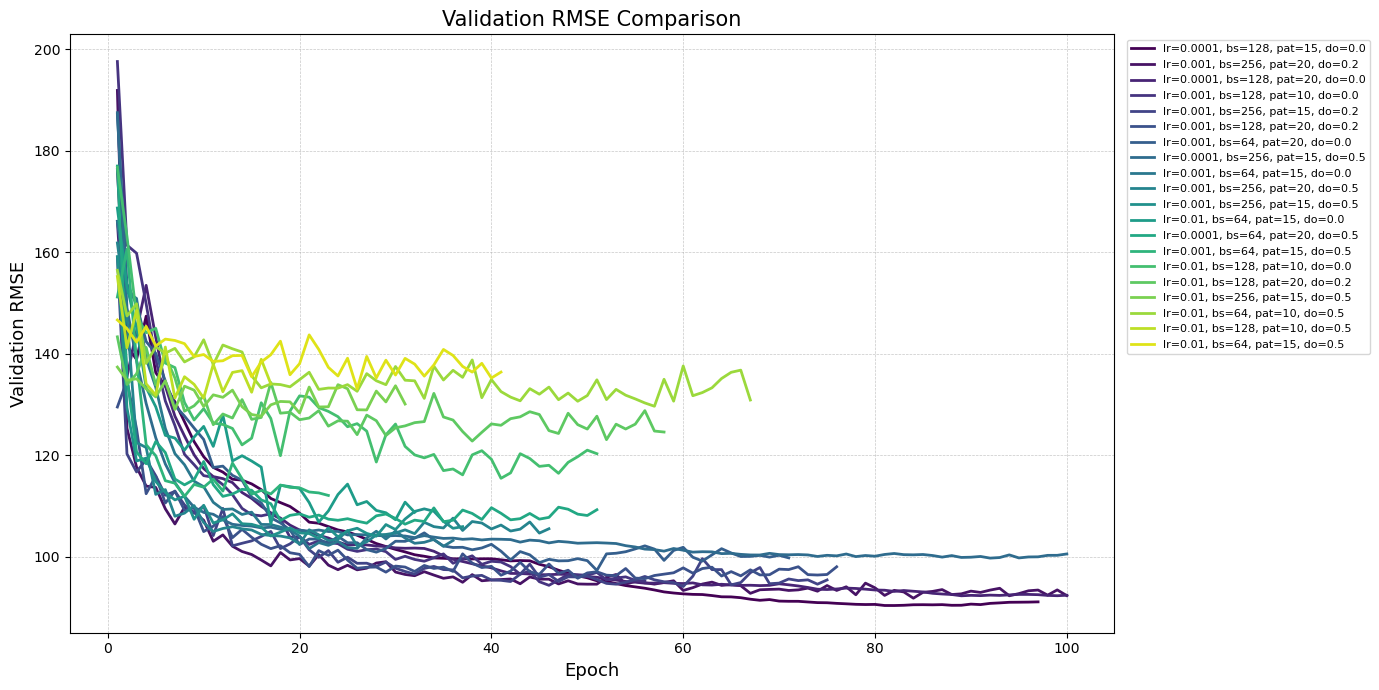

In [72]:
plot_all_val_rmse(all_results, model_params)